In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:.2f}')
pd.set_option('display.max_columns', None)

In [74]:
# Load and prepare data
df = pd.read_csv('mon_final.csv', index_col=0)
df.columns = df.columns.str.strip().str.lower()

# Rename columns
column_mapping = {
    'committed_sign_revenue': 'committed_signed',
    'committed_unsig_revenue': 'committed_unsigned',
    'wtd_pipeline_revenue': 'wtd_pipeline'
}

for old_name, new_name in column_mapping.items():
    if old_name in df.columns:
        df = df.rename(columns={old_name: new_name})

df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month_num'].astype(str) + '-01')
df = df.sort_values('date').reset_index(drop=True)

month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df['month_name'] = df['month_num'].map(month_names)

print(f"Data Shape: {df.shape}")
print(f"Date Range: {df['date'].min().strftime('%Y-%m')} to {df['date'].max().strftime('%Y-%m')}")

Data Shape: (33, 10)
Date Range: 2023-03 to 2025-11


# ENHANCED FEATURE ENGINEERING WITH OVERPREDICTION CORRECTION FEATURES

In [75]:
def engineer_enhanced_features(df):
    df = df.copy().sort_values('date').reset_index(drop=True)

    # ========== ORIGINAL FEATURES ==========
    df['total_forecast'] = df['committed_signed'].fillna(0) + df['committed_unsigned'].fillna(0) + df['wtd_pipeline'].fillna(0)
    df['remaining_months'] = 12 - df['month_num'] + 1
    df['signed_monthly_run_rate'] = df['committed_signed'] / df['remaining_months']
    df['unsigned_monthly_run_rate'] = df['committed_unsigned'] / df['remaining_months']
    df['pipeline_monthly_run_rate'] = df['wtd_pipeline'] / df['remaining_months']
    df['total_monthly_run_rate'] = df['signed_monthly_run_rate'] + df['unsigned_monthly_run_rate'] + df['pipeline_monthly_run_rate']
    df['signed_conversion_ratio'] = df['committed_signed'] / (df['total_forecast'] + 1e-10)
    df['pipeline_conversion_ratio'] = df['wtd_pipeline'] / (df['total_forecast'] + 1e-10)
    df['time_pressure'] = 1 / (df['remaining_months'] + 0.5)
    df['quarter'] = ((df['month_num'] - 1) // 3) + 1
    df['quarter_progress'] = ((df['month_num'] - 1) % 3) / 3

    # Business cycle
    df['business_cycle'] = pd.cut(df['month_num'], bins=[0, 4, 8, 13], labels=['early', 'mid', 'late'])
    cycle_map = {'early': 0, 'mid': 0.5, 'late': 1}
    df['business_cycle_score'] = df['business_cycle'].map(cycle_map).astype(float)
    df['ytd_progress'] = (df['month_num'] - 1) / 11

    # Growth features
    for col in ['committed_signed', 'wtd_pipeline']:
        df[f'{col}_yoy_growth'] = ((df[col] - df.groupby('month_num')[col].shift(1)) / (df.groupby('month_num')[col].shift(1) + 1e-10))

    df['actual_revenue_yoy_growth'] = df['actual_revenue'].shift(1) - df.groupby('month_num')['actual_revenue'].shift(2) / (df.groupby('month_num')['actual_revenue'].shift(1) + 1e-10)
    df['revenue_mom_growth'] = df['actual_revenue'].shift(1).pct_change(1)
    df['signed_mom_growth'] = df['committed_signed'].pct_change(1)
    df['revenue_3m_growth'] = df['actual_revenue'].shift(1).pct_change(3)
    df['pipeline_3m_growth'] = df['wtd_pipeline'].pct_change(3)

    # Run rate analysis
    df['current_monthly_run'] = df['actual_revenue'].shift(1).rolling(3, min_periods=1).mean()
    df['required_monthly_run'] = df['signed_monthly_run_rate']
    df['run_rate_gap'] = df['required_monthly_run'] - df['current_monthly_run']
    df['run_rate_gap_pct'] = df['run_rate_gap'] / (df['current_monthly_run'] + 1e-10)

    df['business_health'] = (0.4 * df['signed_conversion_ratio'] + 0.3 * (1 - df['run_rate_gap_pct'].clip(-1, 1).abs()) + 0.2 * df['business_cycle_score'])
    df['pressure_efficiency'] = df['time_pressure'] * df['signed_conversion_ratio']
    df['time_adjusted_pipeline'] = df['wtd_pipeline'] * np.exp(-0.1 * (df['remaining_months'] - 1))
    df['signed_cycle_importance'] = df['committed_signed'] * (1 - df['business_cycle_score'])

    # Log transforms
    df['log_signed_monthly'] = np.log1p(df['signed_monthly_run_rate'])
    df['log_pipeline_monthly'] = np.log1p(df['pipeline_monthly_run_rate'])
    df['log_actual_revenue_lag_1'] = np.log1p(df['actual_revenue'].shift(1))
    df['log_actual_revenue_lag_2'] = np.log1p(df['actual_revenue'].shift(2))
    df['log_actual_revenue_lag_3'] = np.log1p(df['actual_revenue'].shift(3))

    df['sqrt_total_forecast'] = np.sqrt(df['total_forecast'])
    df['signed_monthly_squared'] = df['signed_monthly_run_rate'] ** 2
    df['pipeline_monthly_squared'] = df['pipeline_monthly_run_rate'] ** 2

    # Lagged features
    for lag in [1, 2, 3]:
        df[f'revenue_lag_{lag}'] = df['actual_revenue'].shift(lag)
        df[f'signed_runrate_lag_{lag}'] = df['signed_monthly_run_rate'].shift(lag)

    # EWM smoothing
    df['revenue_ewm_6m'] = df['actual_revenue'].shift(1).ewm(span=6, adjust=False).mean()
    df['signed_ewm_6m'] = df['signed_monthly_run_rate'].ewm(span=6, adjust=False).mean()

    # Rolling statistics
    df['revenue_rolling_3m_mean'] = df['actual_revenue'].shift(1).rolling(window=3, min_periods=1).mean()
    df['revenue_rolling_6m_std'] = df['actual_revenue'].shift(1).rolling(window=6, min_periods=1).std()

    df['pipeline_velocity'] = df['wtd_pipeline'] / (df['remaining_months'] + 0.5)
    df['signed_momentum'] = df['signed_mom_growth'].diff(1)
    df['revenue_predictability'] = 1 / (1 + df['revenue_rolling_6m_std'] / (df['revenue_rolling_3m_mean'] + 1e-10))
    df['forecast_achievability'] = (df['signed_monthly_run_rate'] / (df['actual_revenue'].rolling(12, min_periods=1).mean() + 1e-10)).clip(0, 3)
    df['quarter_intensity'] = df['quarter'].map({1: 0.8, 2: 0.9, 3: 1.0, 4: 1.2})

    # ========== NEW FEATURES TO ADDRESS OVERPREDICTION ==========

    # 1. FORECAST ACCURACY METRICS
    df['forecast_bias_3m'] = (df['committed_signed'].shift(3) - df['actual_revenue'].rolling(3, min_periods=1).mean()) / (df['actual_revenue'].rolling(3, min_periods=1).mean() + 1e-10)
    df['forecast_bias_6m'] = (df['committed_signed'].shift(6) - df['actual_revenue'].rolling(6, min_periods=1).mean()) / (df['actual_revenue'].rolling(6, min_periods=1).mean() + 1e-10)
    df['signed_forecast_volatility'] = df['committed_signed'].pct_change().rolling(3, min_periods=1).std()
    df['pipeline_forecast_volatility'] = df['wtd_pipeline'].pct_change().rolling(3, min_periods=1).std()

    # 2. TIME-BASED FORECAST DECAY
    df['forecast_decay_factor'] = np.exp(-0.15 * (df['remaining_months'] - 1))
    df['signed_decayed'] = df['committed_signed'] * df['forecast_decay_factor']
    df['pipeline_decayed'] = df['wtd_pipeline'] * df['forecast_decay_factor'] * df['avg_prob_pct']
    df['signed_decayed_monthly'] = df['signed_decayed'] / df['remaining_months']
    df['pipeline_decayed_monthly'] = df['pipeline_decayed'] / df['remaining_months']

    # 3. HISTORICAL PERFORMANCE vs FORECAST
    for lag in [12, 24]:
        if len(df) > lag:
            df[f'actual_vs_forecast_lag_{lag}'] = df['actual_revenue'].shift(lag) / (df['committed_signed'].shift(lag) + 1e-10)

    df['forecast_accuracy_3m'] = 1 - (abs(df['committed_signed'].shift(3) - df['actual_revenue'].rolling(3, min_periods=1).mean()) / (df['actual_revenue'].rolling(3, min_periods=1).mean() + 1e-10))
    df['forecast_accuracy_6m'] = 1 - (abs(df['committed_signed'].shift(6) - df['actual_revenue'].rolling(6, min_periods=1).mean()) / (df['actual_revenue'].rolling(6, min_periods=1).mean() + 1e-10))

    # 4. PIPELINE CONVERSION VELOCITY
    df['pipeline_conversion_rate'] = df['committed_signed'].shift(1) / (df['wtd_pipeline'].shift(1) + df['committed_signed'].shift(1) + 1e-10)
    df['pipeline_growth_acceleration'] = df['wtd_pipeline'].diff().diff()
    df['signed_growth_acceleration'] = df['committed_signed'].diff().diff()

    # 5. ENHANCED SEASONALITY
    month_effects = {1: 0.9, 2: 0.85, 3: 1.1, 4: 1.05, 5: 1.0, 6: 0.95, 7: 0.9, 8: 0.95, 9: 1.0, 10: 1.1, 11: 1.15, 12: 1.2}
    df['month_effect'] = df['month_num'].map(month_effects)
    df['holiday_effect'] = ((df['month_num'] >= 10) & (df['month_num'] <= 12)).astype(float) * 1.15
    df['summer_slowdown'] = ((df['month_num'] >= 6) & (df['month_num'] <= 8)).astype(float) * 0.9

    # 6. BUSINESS MOMENTUM
    df['conversion_momentum'] = df['signed_conversion_ratio'].diff(3)
    df['run_rate_momentum'] = df['signed_monthly_run_rate'].pct_change(3)
    df['business_momentum'] = (0.4 * df['conversion_momentum'] + 0.3 * df['run_rate_momentum'] + 0.3 * df['revenue_3m_growth'])

    # 7. FORECAST RELIABILITY SCORES
    df['forecast_optimism'] = df['committed_signed'] / (df['actual_revenue'].rolling(12, min_periods=1).mean() + 1e-10)
    df['probability_adjusted_reliability'] = df['avg_prob_pct'] * (1 - df['forecast_optimism'].clip(0, 2) / 2)
    df['forecast_error_trend'] = df['forecast_bias_3m'].diff(3)

    # 8. INTERACTION TERMS WITH TIME
    df['time_adjusted_conversion'] = df['signed_conversion_ratio'] * (1 / (df['remaining_months'] + 0.5))
    df['decay_adjusted_pipeline_value'] = df['wtd_pipeline'] * df['forecast_decay_factor'] * df['avg_prob_pct']
    df['seasonally_adjusted_run_rate'] = df['signed_monthly_run_rate'] * df['month_effect']

    # 9. VOLATILITY AND RISK METRICS
    df['revenue_volatility_6m'] = df['actual_revenue'].rolling(6, min_periods=1).std() / (df['actual_revenue'].rolling(6, min_periods=1).mean() + 1e-10)
    df['forecast_stability'] = 1 / (1 + df['signed_forecast_volatility'])
    df['risk_adjusted_forecast'] = df['signed_monthly_run_rate'] * df['forecast_stability']

    # 10. ADVANCED TEMPORAL FEATURES
    #df['yoy_seasonality_factor'] = df.groupby('month_num')['actual_revenue'].transform(lambda x: x.pct_change(12).mean())
    df['revenue_macd'] = df['actual_revenue'].ewm(span=3, adjust=False).mean() - df['actual_revenue'].ewm(span=6, adjust=False).mean()
    df['trend_strength'] = df['actual_revenue'].rolling(6, min_periods=1).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0)

    return df

# Apply enhanced feature engineering
df = engineer_enhanced_features(df)

print(f"Created {len([col for col in df.columns if col not in ['year', 'month', 'month_num', 'actual_revenue', 'business_cycle', 'committed_signed', 'committed_unsigned', 'wtd_pipeline', 'avg_prob_pct', 'date', 'month_name']])} new features!")
print(f"Total columns now: {df.shape[1]}")

# Display new feature categories
new_features = [col for col in df.columns if col not in ['year', 'month', 'month_num', 'actual_revenue', 'business_cycle', 'committed_signed', 'committed_unsigned', 'wtd_pipeline', 'avg_prob_pct', 'date', 'month_name']]

feature_categories = {
    'FORECAST ACCURACY': [col for col in new_features if any(x in col for x in ['forecast_bias', 'forecast_accuracy', 'forecast_volatility'])],
    'DECAY ADJUSTED': [col for col in new_features if any(x in col for x in ['decay', 'decayed'])],
    'SEASONALITY ENHANCED': [col for col in new_features if any(x in col for x in ['month_effect', 'holiday_effect', 'summer_slowdown', 'yoy_seasonality'])],
    'RELIABILITY SCORES': [col for col in new_features if any(x in col for x in ['forecast_optimism', 'probability_adjusted_reliability', 'forecast_error_trend'])],
    'MOMENTUM INDICATORS': [col for col in new_features if any(x in col for x in ['momentum', 'acceleration'])],
    'VOLATILITY RISK': [col for col in new_features if any(x in col for x in ['volatility', 'risk_adjusted', 'stability'])]
}

# Calculate all features already assigned to categories
all_assigned_features = [item for sublist in feature_categories.values() for item in sublist]

# Then, define the 'ORIGINAL FEATURES' category
feature_categories['ORIGINAL FEATURES'] = [col for col in new_features if col not in all_assigned_features]

print("\nFEATURE CATEGORIES CREATED:")
for category, features in feature_categories.items():
    if features:
        print(f"  {category}: {len(features)} features")

Created 84 new features!
Total columns now: 95

FEATURE CATEGORIES CREATED:
  FORECAST ACCURACY: 6 features
  DECAY ADJUSTED: 6 features
  SEASONALITY ENHANCED: 3 features
  RELIABILITY SCORES: 3 features
  MOMENTUM INDICATORS: 6 features
  VOLATILITY RISK: 5 features
  ORIGINAL FEATURES: 57 features


In [76]:
lst=['year','month','actual_revenue','date','month_name']

# KEY NEW FEATURES TO ADDRESS OVERPREDICTION

In [77]:
print("\nTOP 10 CRITICAL FEATURES FOR OVERPREDICTION CORRECTION:")
critical_features = [
    'forecast_bias_3m',          # Historical forecast accuracy
    'forecast_bias_6m',          # Longer-term forecast bias
    'forecast_decay_factor',     # Time-based decay of forecasts
    'forecast_optimism',         # How optimistic forecasts are
    'probability_adjusted_reliability',  # Weighted reliability
    'signed_decayed_monthly',    # Decay-adjusted run rate
    'month_effect',              # Month-specific seasonality
    'business_momentum',         # Business acceleration/deceleration
    'revenue_volatility_6m',     # Revenue stability
    'risk_adjusted_forecast'     # Stability-adjusted forecast
]

for feat in critical_features:
    if feat in df.columns:
        print(f"  ✓ {feat}")

print("\nThese features help the model:")
print("  1. Recognize historically optimistic forecasts")
print("  2. Apply appropriate time-based decay")
print("  3. Adjust for seasonal patterns")
print("  4. Account for business momentum")
print("  5. Weight forecasts by reliability and stability")


TOP 10 CRITICAL FEATURES FOR OVERPREDICTION CORRECTION:
  ✓ forecast_bias_3m
  ✓ forecast_bias_6m
  ✓ forecast_decay_factor
  ✓ forecast_optimism
  ✓ probability_adjusted_reliability
  ✓ signed_decayed_monthly
  ✓ month_effect
  ✓ business_momentum
  ✓ revenue_volatility_6m
  ✓ risk_adjusted_forecast

These features help the model:
  1. Recognize historically optimistic forecasts
  2. Apply appropriate time-based decay
  3. Adjust for seasonal patterns
  4. Account for business momentum
  5. Weight forecasts by reliability and stability


In [78]:
# Filter to only existing features
#ALL_FEATURES = [f for f in ALL_FEATURES if f in df.columns]
lst=['year','month','actual_revenue','date','month_name','yoy_seasonality_factor','business_cycle']
ALL_FEATURES = [f for f in df.columns if f not in lst]
TARGET = 'actual_revenue'

print(f"\nTotal features for modeling: {len(ALL_FEATURES)}")
print(f"Target variable: {TARGET}")


Total features for modeling: 89
Target variable: actual_revenue


In [79]:
from sklearn.impute import SimpleImputer

# Initialize imputer with 'median' strategy
imputer = SimpleImputer(strategy='median')

# Fit and transform the data (returns a NumPy array)
df = df = df.fillna(df.median(numeric_only=True))

df

,year,month,month_num,actual_revenue,wtd_pipeline,committed_unsigned,committed_signed,avg_prob_pct,date,month_name,total_forecast,remaining_months,signed_monthly_run_rate,unsigned_monthly_run_rate,pipeline_monthly_run_rate,total_monthly_run_rate,signed_conversion_ratio,pipeline_conversion_ratio,time_pressure,quarter,quarter_progress,business_cycle,business_cycle_score,ytd_progress,committed_signed_yoy_growth,wtd_pipeline_yoy_growth,actual_revenue_yoy_growth,revenue_mom_growth,signed_mom_growth,revenue_3m_growth,pipeline_3m_growth,current_monthly_run,required_monthly_run,run_rate_gap,run_rate_gap_pct,business_health,pressure_efficiency,time_adjusted_pipeline,signed_cycle_importance,log_signed_monthly,log_pipeline_monthly,log_actual_revenue_lag_1,log_actual_revenue_lag_2,log_actual_revenue_lag_3,sqrt_total_forecast,signed_monthly_squared,pipeline_monthly_squared,revenue_lag_1,signed_runrate_lag_1,revenue_lag_2,signed_runrate_lag_2,revenue_lag_3,signed_runrate_lag_3,revenue_ewm_6m,signed_ewm_6m,revenue_rolling_3m_mean,revenue_rolling_6m_std,pipeline_velocity,signed_momentum,revenue_predictability,forecast_achievability,quarter_intensity,forecast_bias_3m,forecast_bias_6m,signed_forecast_volatility,pipeline_forecast_volatility,forecast_decay_factor,signed_decayed,pipeline_decayed,signed_decayed_monthly,pipeline_decayed_monthly,actual_vs_forecast_lag_12,actual_vs_forecast_lag_24,forecast_accuracy_3m,forecast_accuracy_6m,pipeline_conversion_rate,pipeline_growth_acceleration,signed_growth_acceleration,month_effect,holiday_effect,summer_slowdown,conversion_momentum,run_rate_momentum,business_momentum,forecast_optimism,probability_adjusted_reliability,forecast_error_trend,time_adjusted_conversion,decay_adjusted_pipeline_value,seasonally_adjusted_run_rate,revenue_volatility_6m,forecast_stability,risk_adjusted_forecast,revenue_macd,trend_strength
0,2023,Mar,3,143652715.00,149498941.00,225341482.20,892333074.90,1.08,2023-03-01,Mar,1267173498.10,10,89233307.49,22534148.22,14949894.10,126717349.81,0.70,0.12,0.10,1,0.67,early,0.00,0.18,0.21,0.00,173445946.99,0.02,-0.12,0.03,-0.53,151965956.02,89233307.49,-26510957.12,-0.17,0.67,0.07,60781733.57,892333074.90,18.31,16.52,18.86,18.86,18.85,35597.38,7962583165604889.00,223499333601214.81,155786526.50,126016467.33,155459389.30,124508324.52,153822350.45,122302307.02,149252117.69,89233307.49,151965956.02,5317104.36,14237994.38,-0.02,0.96,0.62,0.80,4.17,4.29,0.04,0.10,0.26,231328658.92,41856635.99,23132865.89,4185663.60,0.21,0.22,-3.17,-3.29,0.91,4812929.31,2439557.20,1.10,0.00,0.00,0.05,0.10,0.06,6.21,0.00,-1.78,0.07,41856635.99,98156638.24,0.04,0.96,119780003.26,0.00,0.00
1,2023,Apr,4,124885992.10,128021173.80,175109527.80,846389431.60,0.30,2023-04-01,Apr,1149520133.20,9,94043270.18,19456614.20,14224574.87,127724459.24,0.74,0.11,0.11,2,0.00,early,0.00,0.27,0.21,0.00,173445946.99,0.02,-0.05,0.03,-0.53,143652715.00,94043270.18,-49609444.82,-0.35,0.49,0.08,57523621.41,846389431.60,18.36,16.47,18.78,18.86,18.85,33904.57,8844136665730508.00,202338530137405.03,143652715.00,89233307.49,155459389.30,124508324.52,153822350.45,122302307.02,143652715.00,90607582.54,143652715.00,5317104.36,13475913.03,-0.02,0.96,0.70,0.90,4.17,4.29,0.04,0.10,0.30,254927597.82,11567770.97,28325288.65,1285307.89,0.21,0.22,-3.17,-3.29,0.86,4812929.31,2439557.20,1.05,0.00,0.00,0.05,0.10,0.06,6.30,0.00,-1.78,0.08,11567770.97,98745433.69,0.10,0.96,119780003.26,-4021440.62,-18766722.90
2,2023,May,5,138875729.00,111183171.10,136708061.70,794282160.00,0.32,2023-05-01,May,1042173392.80,8,99285270.00,17088507.71,13897896.39,130271674.10,0.76,0.11,0.12,2,0.33,mid,0.50,0.36,0.21,0.00,173445946.99,-0.13,-0.06,0.03,-0.53,134269353.55,99285270.00,-34984083.55,-0.26,0.63,0.09,55211928.80,397141080.00,18.41,16.45,18.64,18.78,18.85,32282.71,9857564838972900.00,193151523997685.53,124885992.10,94043270.18,143652715.00,89233307.49,153822350.45,122302307.02,138290794.17,93086921.82,134269353.55,13270077.02,13080373.07,-0.01,0.91,0.73,0.90,4.17,4.29,

In [80]:
df.isnull().sum()

,0
year,0
month,0
month_num,0
actual_revenue,0
wtd_pipeline,0
...,...
revenue_volatility_6m,0
forecast_stability,0
risk_adjusted_forecast,0
revenue_macd,0


In [81]:
# ============================================
# STEP 8: CHECK FOR TARGET LEAKAGE
# ============================================

"""
TARGET LEAKAGE CHECK:
- Features should NOT have correlation > 0.95 with target
- If they do, they likely contain target information
"""

print("🔍 Checking for target leakage...")
print("="*60)

# Calculate correlations with target
correlations = df[ALL_FEATURES + [TARGET]].corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)

print("\nTop 20 features by correlation with target:")
for feat, corr in correlations.head(20).items():
    status = "⚠️ POTENTIAL LEAKAGE" if corr > 0.95 else "✅ OK"
    print(f"   {feat}: {corr:.4f} {status}")

# Remove features with too high correlation (potential leakage)
leakage_features = correlations[correlations > 0.95].index.tolist()

if leakage_features:
    print(f"\n⚠️ Removing potential leakage features: {leakage_features}")
    FINAL_FEATURES = [f for f in ALL_FEATURES if f not in leakage_features]
else:
    print("\n✅ No target leakage detected!")
    FINAL_FEATURES = ALL_FEATURES.copy()

print(f"\n📊 Feature count after leakage check: {len(FINAL_FEATURES)}")

🔍 Checking for target leakage...

Top 20 features by correlation with target:
   current_monthly_run: 0.9261 ✅ OK
   revenue_rolling_3m_mean: 0.9261 ✅ OK
   revenue_ewm_6m: 0.9170 ✅ OK
   revenue_lag_1: 0.8801 ✅ OK
   log_actual_revenue_lag_1: 0.8739 ✅ OK
   revenue_lag_3: 0.8497 ✅ OK
   log_actual_revenue_lag_3: 0.8441 ✅ OK
   revenue_lag_2: 0.8298 ✅ OK
   log_actual_revenue_lag_2: 0.8194 ✅ OK
   signed_ewm_6m: 0.8169 ✅ OK
   revenue_macd: 0.7878 ✅ OK
   avg_prob_pct: 0.7792 ✅ OK
   signed_decayed: 0.7453 ✅ OK
   pipeline_decayed_monthly: 0.7397 ✅ OK
   log_signed_monthly: 0.6130 ✅ OK
   revenue_volatility_6m: 0.6104 ✅ OK
   revenue_predictability: 0.6014 ✅ OK
   signed_runrate_lag_3: 0.5600 ✅ OK
   pipeline_decayed: 0.5303 ✅ OK
   decay_adjusted_pipeline_value: 0.5303 ✅ OK

✅ No target leakage detected!

📊 Feature count after leakage check: 89


In [82]:
# ============================================
# STEP 9: CHECK MULTICOLLINEARITY
# ============================================

"""
MULTICOLLINEARITY CHECK:
- Highly correlated features (>0.90) can destabilize linear models
- Keep the one more correlated with target
"""

print("🔍 Checking for multicollinearity...")
print("="*60)

# Calculate pairwise correlations
corr_matrix = df[ALL_FEATURES].corr().abs()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.90:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print(f"\n⚠️ Found {len(high_corr_pairs)} highly correlated feature pairs:")

    features_to_drop = set()
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: -x[2])[:20]:
        # Keep the one more correlated with target
        corr1 = correlations.get(feat1, 0)
        corr2 = correlations.get(feat2, 0)

        if corr1 >= corr2:
            to_drop = feat2
            to_keep = feat1
        else:
            to_drop = feat1
            to_keep = feat2

        features_to_drop.add(to_drop)
        print(f"   {feat1} ↔ {feat2}: {corr:.3f} → Drop {to_drop}, Keep {to_keep}")

    FINAL_FEATURES = [f for f in ALL_FEATURES if f not in features_to_drop]
    print(f"\n✅ Removed {len(features_to_drop)} redundant features")
else:
    print("✅ No severe multicollinearity detected!")

print(f"\n📊 Final feature count after multicollinearity check: {len(FINAL_FEATURES)}")
print(f"\n📋 Final Features ({len(FINAL_FEATURES)}):")
for i, feat in enumerate(FINAL_FEATURES, 1):
    print(f"   {i:2d}. {feat}")

🔍 Checking for multicollinearity...

⚠️ Found 242 highly correlated feature pairs:
   month_num ↔ remaining_months: 1.000 → Drop remaining_months, Keep month_num
   signed_monthly_run_rate ↔ required_monthly_run: 1.000 → Drop required_monthly_run, Keep signed_monthly_run_rate
   current_monthly_run ↔ revenue_rolling_3m_mean: 1.000 → Drop revenue_rolling_3m_mean, Keep current_monthly_run
   pressure_efficiency ↔ time_adjusted_conversion: 1.000 → Drop time_adjusted_conversion, Keep pressure_efficiency
   forecast_bias_3m ↔ forecast_accuracy_3m: 1.000 → Drop forecast_bias_3m, Keep forecast_accuracy_3m
   forecast_bias_6m ↔ forecast_accuracy_6m: 1.000 → Drop forecast_bias_6m, Keep forecast_accuracy_6m
   pipeline_decayed ↔ decay_adjusted_pipeline_value: 1.000 → Drop decay_adjusted_pipeline_value, Keep pipeline_decayed
   month_num ↔ ytd_progress: 1.000 → Drop month_num, Keep ytd_progress
   remaining_months ↔ ytd_progress: 1.000 → Drop remaining_months, Keep ytd_progress
   signed_forecast

In [83]:
lst=['year','month','actual_revenue','date','month_name','yoy_seasonality_factor','business_cycle']
FINAL_FEATURES = [f for f in ALL_FEATURES if f not in lst]
FINAL_FEATURES

['month_num',
 'wtd_pipeline',
 'committed_unsigned',
 'committed_signed',
 'avg_prob_pct',
 'total_forecast',
 'remaining_months',
 'signed_monthly_run_rate',
 'unsigned_monthly_run_rate',
 'pipeline_monthly_run_rate',
 'total_monthly_run_rate',
 'signed_conversion_ratio',
 'pipeline_conversion_ratio',
 'time_pressure',
 'quarter',
 'quarter_progress',
 'business_cycle_score',
 'ytd_progress',
 'committed_signed_yoy_growth',
 'wtd_pipeline_yoy_growth',
 'actual_revenue_yoy_growth',
 'revenue_mom_growth',
 'signed_mom_growth',
 'revenue_3m_growth',
 'pipeline_3m_growth',
 'current_monthly_run',
 'required_monthly_run',
 'run_rate_gap',
 'run_rate_gap_pct',
 'business_health',
 'pressure_efficiency',
 'time_adjusted_pipeline',
 'signed_cycle_importance',
 'log_signed_monthly',
 'log_pipeline_monthly',
 'log_actual_revenue_lag_1',
 'log_actual_revenue_lag_2',
 'log_actual_revenue_lag_3',
 'sqrt_total_forecast',
 'signed_monthly_squared',
 'pipeline_monthly_squared',
 'revenue_lag_1',
 's

In [84]:
# ============================================
# STEP 10: TRAIN-TEST SPLIT
# ============================================

"""
TEMPORAL SPLIT:
- Training: 2023-2024 (historical data)
- Testing: 2025 (simulate forecasting)

REASONING:
- This mimics real-world scenario: train on past, predict future
- No data leakage from future to past
"""

# Split data
train_df = df[df['year'].isin([2023, 2024])].copy()
test_df = df[df['year'] == 2025].copy()

# Remove rows where target is NaN in training data
train_df = train_df[train_df[TARGET].notna()]

print(f"📚 Training Data: {len(train_df)} rows (2023-2024)")
print(f"🧪 Test Data: {len(test_df)} rows (2025)")
print(f"\n📅 Training months: {train_df['year'].unique()} - {sorted(train_df['month_num'].unique())}")
print(f"📅 Test months: {sorted(test_df['month_num'].unique())}")

# Check which test months have actual values
test_with_actual = test_df[test_df[TARGET].notna()]
test_without_actual = test_df[test_df[TARGET].isna()]

print(f"\n📊 Test months with actual values: {sorted(test_with_actual['month_num'].unique())}")
print(f"📊 Test months without actual (need EWM imputation): {sorted(test_without_actual['month_num'].unique())}")

📚 Training Data: 22 rows (2023-2024)
🧪 Test Data: 11 rows (2025)

📅 Training months: [2023 2024] - [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]
📅 Test months: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]

📊 Test months with actual values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
📊 Test months without actual (need EWM imputation): []


In [85]:
def create_future_months_with_ewm(df, year, available_months, max_month=12, ewm_span=6):
    """
    Create rows for future months and impute features using EWM.

    Args:
        df: Full dataframe with historical data
        year: Target year
        available_months: List of months that have actual forecast data
        max_month: Maximum month to generate (12 = December)
        ewm_span: Span for exponential weighted mean
    """
    df = df.copy()

    # Ensure 'is_imputed' column exists and is boolean. Fill any NaNs with False.
    if 'is_imputed' not in df.columns:
        df['is_imputed'] = False
    else:
        df['is_imputed'] = df['is_imputed'].fillna(False).astype(bool)

    # Find months that need to be created
    all_months = list(range(1, max_month + 1))
    existing_months = df[(df['year'] == year)]['month_num'].unique().tolist()
    missing_months = [m for m in all_months if m not in existing_months]

    if not missing_months:
        print(f"   No missing months to create for {year}")
        return df

    print(f"   Creating rows for months: {missing_months}")

    # For each missing month, create a row with EWM-imputed features
    new_rows = []

    for month in missing_months:
        # Get historical data for EWM calculation
        historical = df[df['date'] < f"{year}-{month:02d}-01"].tail(ewm_span * 2)

        if len(historical) == 0:
            continue

        new_row = {
            'year': year,
            'month_num': month,
            'month_name': {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
                          7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}[month],
            'date': pd.Timestamp(f"{year}-{month:02d}-01"),
            'is_imputed': True  # Mark as imputed
        }

        # Impute numeric features using EWM
        numeric_cols = historical.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if col in ['year', 'month_num']:
                continue
            ewm_val = historical[col].ewm(span=ewm_span, adjust=False).mean().iloc[-1]
            new_row[col] = ewm_val

        new_rows.append(new_row)

    if new_rows:
        new_df = pd.DataFrame(new_rows)
        # The 'is_imputed' column in df is now correctly boolean, so no need for df.get() here.
        df = pd.concat([df, new_df], ignore_index=True)
        df = df.sort_values('date').reset_index(drop=True)

    return df

# Mark existing test data as not imputed
test_df['is_imputed'] = False

# Get available months in test data
available_test_months = sorted(test_df['month_num'].unique().tolist())
print(f"\n📅 Available test months: {available_test_months}")

# Create future months if needed
print("\n🔄 Creating future months with EWM imputation...")

# Combine train and test for EWM calculation
# Ensure 'is_imputed' is consistently False for train_df before concat
train_df_temp = train_df.copy()
train_df_temp['is_imputed'] = False
combined_df = pd.concat([train_df_temp, test_df], ignore_index=True).sort_values('date')

combined_df = create_future_months_with_ewm(combined_df, 2025, available_test_months)

# Extract updated test data
test_df = combined_df[combined_df['year'] == 2025].copy()

print(f"\n✅ Test data now has {len(test_df)} months")
print(f"   Actual data months: {sorted(test_df[~test_df['is_imputed']]['month_num'].unique())}")
print(f"   Imputed months: {sorted(test_df[test_df['is_imputed']]['month_num'].unique())}")



📅 Available test months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

🔄 Creating future months with EWM imputation...
   Creating rows for months: [12]

✅ Test data now has 12 months
   Actual data months: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
   Imputed months: [np.int64(12)]


In [86]:
test_df

,year,month,month_num,actual_revenue,wtd_pipeline,committed_unsigned,committed_signed,avg_prob_pct,date,month_name,total_forecast,remaining_months,signed_monthly_run_rate,unsigned_monthly_run_rate,pipeline_monthly_run_rate,total_monthly_run_rate,signed_conversion_ratio,pipeline_conversion_ratio,time_pressure,quarter,quarter_progress,business_cycle,business_cycle_score,ytd_progress,committed_signed_yoy_growth,wtd_pipeline_yoy_growth,actual_revenue_yoy_growth,revenue_mom_growth,signed_mom_growth,revenue_3m_growth,pipeline_3m_growth,current_monthly_run,required_monthly_run,run_rate_gap,run_rate_gap_pct,business_health,pressure_efficiency,time_adjusted_pipeline,signed_cycle_importance,log_signed_monthly,log_pipeline_monthly,log_actual_revenue_lag_1,log_actual_revenue_lag_2,log_actual_revenue_lag_3,sqrt_total_forecast,signed_monthly_squared,pipeline_monthly_squared,revenue_lag_1,signed_runrate_lag_1,revenue_lag_2,signed_runrate_lag_2,revenue_lag_3,signed_runrate_lag_3,revenue_ewm_6m,signed_ewm_6m,revenue_rolling_3m_mean,revenue_rolling_6m_std,pipeline_velocity,signed_momentum,revenue_predictability,forecast_achievability,quarter_intensity,forecast_bias_3m,forecast_bias_6m,signed_forecast_volatility,pipeline_forecast_volatility,forecast_decay_factor,signed_decayed,pipeline_decayed,signed_decayed_monthly,pipeline_decayed_monthly,actual_vs_forecast_lag_12,actual_vs_forecast_lag_24,forecast_accuracy_3m,forecast_accuracy_6m,pipeline_conversion_rate,pipeline_growth_acceleration,signed_growth_acceleration,month_effect,holiday_effect,summer_slowdown,conversion_momentum,run_rate_momentum,business_momentum,forecast_optimism,probability_adjusted_reliability,forecast_error_trend,time_adjusted_conversion,decay_adjusted_pipeline_value,seasonally_adjusted_run_rate,revenue_volatility_6m,forecast_stability,risk_adjusted_forecast,revenue_macd,trend_strength,is_imputed
22,2025,Jan,1,161804911.30,295167291.00,340649474.40,1659868684.00,0.66,2025-01-01,Jan,2295685449.40,12.00,138322390.33,28387456.20,24597274.25,191307120.78,0.72,0.13,0.08,1.00,0.00,early,0.00,0.00,0.54,0.41,173445946.99,0.03,5.51,0.02,18.20,160475043.57,138322390.33,-22152653.23,-0.14,0.55,0.06,98252656.03,1659868684.00,18.75,17.02,18.90,18.87,18.90,47913.31,19133083667527028.00,605025900529713.00,162019263.80,254968903.50,157117614.00,144473444.80,162288252.90,137392718.43,158211624.07,158988029.02,160475043.57,2790472.75,23613383.28,5.63,0.98,0.89,0.80,1.57,3.67,3.30,25.92,0.19,318777629.08,37587562.14,26564802.42,3132296.84,0.13,0.22,-0.57,-2.67,0.98,290730579.28,1438877766.60,0.90,0.00,0.00,-0.14,0.01,-0.05,10.70,0.00,-2.12,0.06,37587562.14,124490151.30,0.02,0.23,32147467.42,1775838.63,874775.73,False
23,2025,Feb,2,163289164.50,224427339.90,270122947.20,1464680581.00,0.24,2025-02-01,Feb,1959230868.10,11.00,133152780.09,24556631.56,20402485.45,178111897.10,0.75,0.11,0.09,1.00,0.33,early,0.00,0.09,0.43,0.26,173445946.99,-0.00,-0.12,-0.00,25.34,160313929.70,133152780.09,-27161149.61,-0.17,0.55,0.07,82562204.39,1464680581.00,18.71,16.83,18.90,18.90,18.87,44263.20,17729662845937998.00,416261412351984.56,161804911.30,138322390.33,162019263.80,254968903.50,157117614.00,144473444.80,159238277.56,151606529.33,160313929.70,2682109.17,19515420.86,-5.63,0.98,0.85,0.80,0.78,2.96,3.25,25.86,0.22,326814412.60,12018361.99,29710401.15,1092578.36,0.14,0.22,0.22,-1.96,0.85,-359428379.92,-1600087883.50,0.85,0.00,0.00,-0.16,-0.08,-0.09,9.34,0.00,-2.21,0.07,12018361.99,113179863.08,0.01,0.24,31336407.86,1755966.51,629153.74,False
24,2025,Mar,3,175925227.90,170640963.30,214197913.50,1292445135.00,2.15,2025-03-01,Mar,1677284011.80,10.00,129244513.50,21419791.35,17064096.33,167728401.18,0.77,0.10,0.10,1.00,0.67,early,0.00,0.18,0.32,0.22,163289163.58,0.01,-0.12,0.04,25.34,162371113.20,129244513.50,-33126599.70,-0.20,0.55,0.07,69377438.39,1292445135.00,18.68,16.65,18.91,18.90,18.90,40954.66,16704144269851682.00,291183383559519.56,163289164.50,133152780.09,161804911.30,138322390.33,162019263.80,254968903.50,

In [87]:
# ============================================
# STEP 12: PREPARE TRAINING DATA
# ============================================

# Prepare features and target
X_train = train_df[FINAL_FEATURES].copy()
y_train = train_df[TARGET].copy()

# Handle any remaining NaNs
X_train = X_train.fillna(0)

print(f"📊 Training Data Shape: X={X_train.shape}, y={y_train.shape}")
print(f"\n📈 Target Statistics:")
print(f"   Min: ${y_train.min():,.2f}")
print(f"   Max: ${y_train.max():,.2f}")
print(f"   Mean: ${y_train.mean():,.2f}")
print(f"   Std: ${y_train.std():,.2f}")

# Scale features
scaler = StandardScaler()  # More robust to outliers
X_train_scaled = scaler.fit_transform(X_train)

print("\n✅ Data prepared and scaled!")

📊 Training Data Shape: X=(22, 89), y=(22,)

📈 Target Statistics:
   Min: $124,885,992.10
   Max: $162,288,252.90
   Mean: $146,002,236.26
   Std: $10,594,945.79

✅ Data prepared and scaled!


In [88]:
# ============================================
# STEP 13: TRAIN MODELS WITH HYPERPARAMETER TUNING
# ============================================

"""
MODEL TRAINING:
- Ridge: L2 regularization (keeps all features but shrinks coefficients)
- Lasso: L1 regularization (can zero out features - feature selection)
- ElasticNet: Combination of L1 and L2 (best of both worlds)

HYPERPARAMETER TUNING:
- Use TimeSeriesSplit for cross-validation (respects temporal order)
- Grid search for optimal alpha and l1_ratio
"""

from sklearn.model_selection import LeaveOneOut

# Use Leave-One-Out for small dataset
cv = LeaveOneOut() if len(X_train) < 30 else TimeSeriesSplit(n_splits=5)

print("🔧 Training models with hyperparameter tuning...")
print("="*60)

# Model configurations with expanded search space
models = {
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        }
    },
    'Lasso': {
        'model': Lasso(random_state=42, max_iter=10000),
        'params': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42, max_iter=10000),
        'params': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]
        }
    }
}

# Train and evaluate each model
trained_models = {}
model_results = []

for name, config in models.items():
    print(f"\n🔄 Training {name}...")

    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    trained_models[name] = best_model

    # Training predictions
    y_train_pred = best_model.predict(X_train_scaled)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    train_r2 = r2_score(y_train, y_train_pred)

    model_results.append({
        'Model': name,
        'Best Params': grid_search.best_params_,
        'CV MAE': -grid_search.best_score_,
        'Train MAE': train_mae,
        'Train RMSE': train_rmse,
        'Train MAPE (%)': train_mape,
        'Train R²': train_r2
    })

    print(f"   Best params: {grid_search.best_params_}")
    print(f"   CV MAE: ${-grid_search.best_score_:,.2f}")
    print(f"   Train R²: {train_r2:.4f}")
    print(f"   Train MAPE: {train_mape:.2f}%")

# Summary table
print("\n" + "="*80)
print("📊 MODEL TRAINING SUMMARY")
print("="*80)
results_df = pd.DataFrame(model_results)
print(results_df.to_string(index=False))

🔧 Training models with hyperparameter tuning...

🔄 Training Ridge...
   Best params: {'alpha': 0.0001}
   CV MAE: $3,790,590.36
   Train R²: 1.0000
   Train MAPE: 0.00%

🔄 Training Lasso...
   Best params: {'alpha': 100.0}
   CV MAE: $9,130,417.99
   Train R²: 1.0000
   Train MAPE: 0.00%

🔄 Training ElasticNet...
   Best params: {'alpha': 0.01, 'l1_ratio': 0.7}
   CV MAE: $3,769,232.01
   Train R²: 1.0000
   Train MAPE: 0.03%

📊 MODEL TRAINING SUMMARY
     Model                      Best Params     CV MAE  Train MAE  Train RMSE  Train MAPE (%)  Train R²
     Ridge                {'alpha': 0.0001} 3790590.36      74.71      102.42            0.00      1.00
     Lasso                 {'alpha': 100.0} 9130417.99    4866.50     6569.54            0.00      1.00
ElasticNet {'alpha': 0.01, 'l1_ratio': 0.7} 3769232.01   46561.85    63540.26            0.03      1.00


In [89]:
# ============================================
# STEP 14: SELECT BEST MODEL & ANALYZE COEFFICIENTS
# ============================================

# Select best model based on CV MAE
best_model_name = min(model_results, key=lambda x: x['CV MAE'])['Model']
best_model = trained_models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"\n📊 Model Coefficients (Top 30 by absolute value):")

# Display coefficients
coefficients = pd.DataFrame({
    'Feature': FINAL_FEATURES,
    'Coefficient': best_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(coefficients.head(30).to_string(index=False))
print(f"\nIntercept: {best_model.intercept_:,.2f}")

# Non-zero coefficients for ElasticNet/Lasso
non_zero = coefficients[coefficients['Coefficient'] != 0]
print(f"\n📊 Non-zero coefficients: {len(non_zero)} / {len(FINAL_FEATURES)}")


🏆 Best Model: ElasticNet

📊 Model Coefficients (Top 30 by absolute value):
                         Feature  Coefficient
                    revenue_macd   4317729.46
                  trend_strength   2388585.06
        log_actual_revenue_lag_3   1667314.55
                   revenue_lag_3   1575839.87
                  holiday_effect   1192062.28
            forecast_accuracy_3m  -1014977.49
                forecast_bias_3m    996128.11
               revenue_3m_growth   -948349.71
         revenue_rolling_3m_mean    940771.39
             current_monthly_run    938394.90
            business_cycle_score    938073.37
                   signed_ewm_6m    892658.35
                  revenue_ewm_6m    842371.27
         wtd_pipeline_yoy_growth   -799362.90
probability_adjusted_reliability    783646.56
                  signed_decayed    776547.29
            signed_runrate_lag_2   -772599.22
        pipeline_monthly_squared    761676.00
            forecast_accuracy_6m   -747018.46
    

In [90]:
df[FINAL_FEATURES].shape

(33, 89)

In [91]:
def create_ewm_features_for_target_month(
    sitting_month_data,   # ✅ name now matches the call
    target_month,
    train_df,
    features,
    month_col='month_num',
    ewm_span=3
):
    """
    Create feature row for ONE target month using EWM propagation.
    """

    # Take the sitting snapshot row
    base_row = sitting_month_data.iloc[0].copy()

    sitting_month = int(base_row[month_col])
    step = target_month - sitting_month
    if step < 0:
        raise ValueError("Target month cannot be before sitting month")

    # Auto-detect numeric feature columns
    numeric_cols = [
        c for c in features
        if c != month_col and pd.api.types.is_numeric_dtype(train_df[c])
    ]

    # Learn historical EWM trend
    ewm_trend = {}
    for col in numeric_cols:
        series = train_df[col].dropna()
        if len(series) >= ewm_span:
            ewm_trend[col] = series.ewm(span=ewm_span, adjust=False).mean().iloc[-1]
        elif len(series) > 0:
            ewm_trend[col] = series.iloc[-1]
        else:
            ewm_trend[col] = 0.0

    # Create target-month feature row
    new_row = base_row.copy()
    new_row[month_col] = target_month

    decay = np.exp(-step / ewm_span)

    for col in numeric_cols:
        base_val = base_row[col]
        trend_val = ewm_trend[col]
        new_row[col] = base_val * decay + trend_val * (1 - decay)

    return pd.DataFrame([new_row])[features]


In [92]:

def rolling_forecast_evaluation(
    test_df, train_df, model, scaler, features, target
):
    """
    Rolling forecast evaluation with correct snapshot logic.
    """

    test_df = test_df.copy().sort_values('month_num')
    test_months = sorted(test_df['month_num'].unique())

    all_results = []
    yearly_results = []

    for start_month in test_months:

        sitting_month_data = test_df[test_df['month_num'] == start_month]
        if sitting_month_data.empty:
            continue
        if sitting_month_data['is_imputed'].iloc[0]:
            continue

        print(f"\n{'='*70}")
        print(f"📅 SITTING IN MONTH {start_month}: FORECASTING MONTH {start_month} → DECEMBER")
        print(f"{'='*70}")

        # YTD actuals
        ytd_actuals = test_df[
            (test_df['month_num'] < start_month) &
            (test_df[target].notna()) &
            (~test_df['is_imputed'])
        ][target].sum()

        month_results = []

        for target_month in range(start_month, 13):

            # 🔑 EWM-based feature population
            month_features = create_ewm_features_for_target_month(
                sitting_month_data=sitting_month_data,
                target_month=target_month,
                train_df=train_df,
                features=features
            )

            X_test = month_features.fillna(0)
            X_test_scaled = scaler.transform(X_test)
            y_pred = model.predict(X_test_scaled)[0]

            target_row = test_df[test_df['month_num'] == target_month]

            if not target_row.empty:
                is_imputed = target_row['is_imputed'].iloc[0]
                y_actual = target_row[target].iloc[0] if not is_imputed else np.nan
                month_name = target_row['month_name'].iloc[0]
            else:
                is_imputed = True
                y_actual = np.nan
                month_name = [
                    'Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'
                ][target_month-1]

            if not pd.isna(y_actual) and not is_imputed:
                error = y_actual - y_pred
                mape = abs(error / y_actual) * 100 if y_actual != 0 else np.nan
            else:
                error = np.nan
                mape = np.nan

            month_results.append({
                'start_month': start_month,
                'forecast_month': target_month,
                'month_name': month_name,
                'actual': y_actual,
                'predicted': y_pred,
                'error': error,
                'mape': mape,
                'is_imputed': is_imputed
            })

        results_df = pd.DataFrame(month_results)

        # Display
        print(f"\n{'Month':<8} {'Actual':>15} {'Predicted':>15} {'Error':>15} {'MAPE (%)':>12} {'Status':>12}")
        print("-" * 80)

        for _, r in results_df.iterrows():
            actual_str = f"${r['actual']:,.0f}" if not pd.isna(r['actual']) else "N/A (Future)"
            error_str = f"${r['error']:,.0f}" if not pd.isna(r['error']) else "-"
            mape_str = f"{r['mape']:.2f}" if not pd.isna(r['mape']) else "-"
            status = "⚡ IMPUTED" if r['is_imputed'] else "✅ ACTUAL"
            print(f"{r['month_name']:<8} {actual_str:>15} ${r['predicted']:>14,.0f} {error_str:>15} {mape_str:>12} {status:>12}")

        total_predicted_remaining = results_df['predicted'].sum()
        actual_months = results_df[~results_df['is_imputed'] & results_df['actual'].notna()]
        total_actual_remaining = actual_months['actual'].sum()

        avg_mape = actual_months['mape'].mean()

        print("-" * 80)
        print(f"\n📊 YEAR-END PROJECTION (Sitting in Month {start_month}):")
        print(f"   YTD Actuals (Jan→{start_month-1}): ${ytd_actuals:,.0f}")
        print(f"   Predicted Remaining ({start_month}→Dec): ${total_predicted_remaining:,.0f}")
        print(f"   TOTAL YEAR-END FORECAST: ${(ytd_actuals + total_predicted_remaining):,.0f}")
        print(f"   Avg MAPE (actual months): {avg_mape:.2f}%")

        yearly_results.append({
            'start_month': start_month,
            'ytd_actuals': ytd_actuals,
            'predicted_remaining': total_predicted_remaining,
            'actual_remaining': total_actual_remaining,
            'avg_mape': avg_mape
        })

        all_results.extend(month_results)

    return pd.DataFrame(all_results), pd.DataFrame(yearly_results)


In [93]:
print(f"\n🚀 Running rolling forecast evaluation with {best_model_name}...")
monthly_results, yearly_results = rolling_forecast_evaluation(
    test_df, train_df, best_model, scaler, FINAL_FEATURES, TARGET
)



🚀 Running rolling forecast evaluation with ElasticNet...

📅 SITTING IN MONTH 1: FORECASTING MONTH 1 → DECEMBER

Month             Actual       Predicted           Error     MAPE (%)       Status
--------------------------------------------------------------------------------
Jan         $161,804,911 $   152,536,338      $9,268,573         5.73     ✅ ACTUAL
Feb         $163,289,164 $   154,673,815      $8,615,349         5.28     ✅ ACTUAL
Mar         $175,925,228 $   156,211,328     $19,713,900        11.21     ✅ ACTUAL
Apr         $170,681,266 $   157,318,948     $13,362,318         7.83     ✅ ACTUAL
May         $172,455,904 $   158,118,537     $14,337,367         8.31     ✅ ACTUAL
Jun         $171,322,481 $   158,697,411     $12,625,070         7.37     ✅ ACTUAL
Jul         $178,908,146 $   159,118,137     $19,790,009        11.06     ✅ ACTUAL
Aug         $173,445,948 $   159,425,544     $14,020,404         8.08     ✅ ACTUAL
Sep         $177,238,137 $   159,651,755     $17,586,382   

📊 Generating rolling forecast plots for each sitting month...


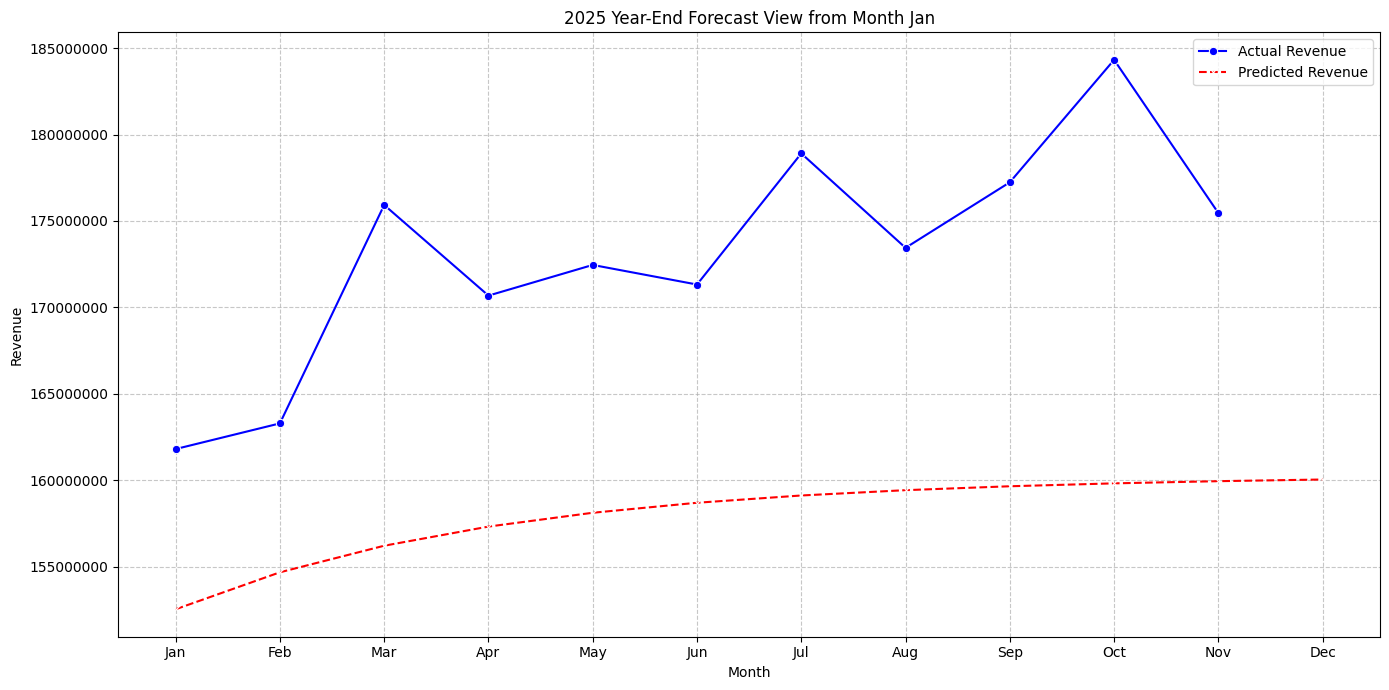

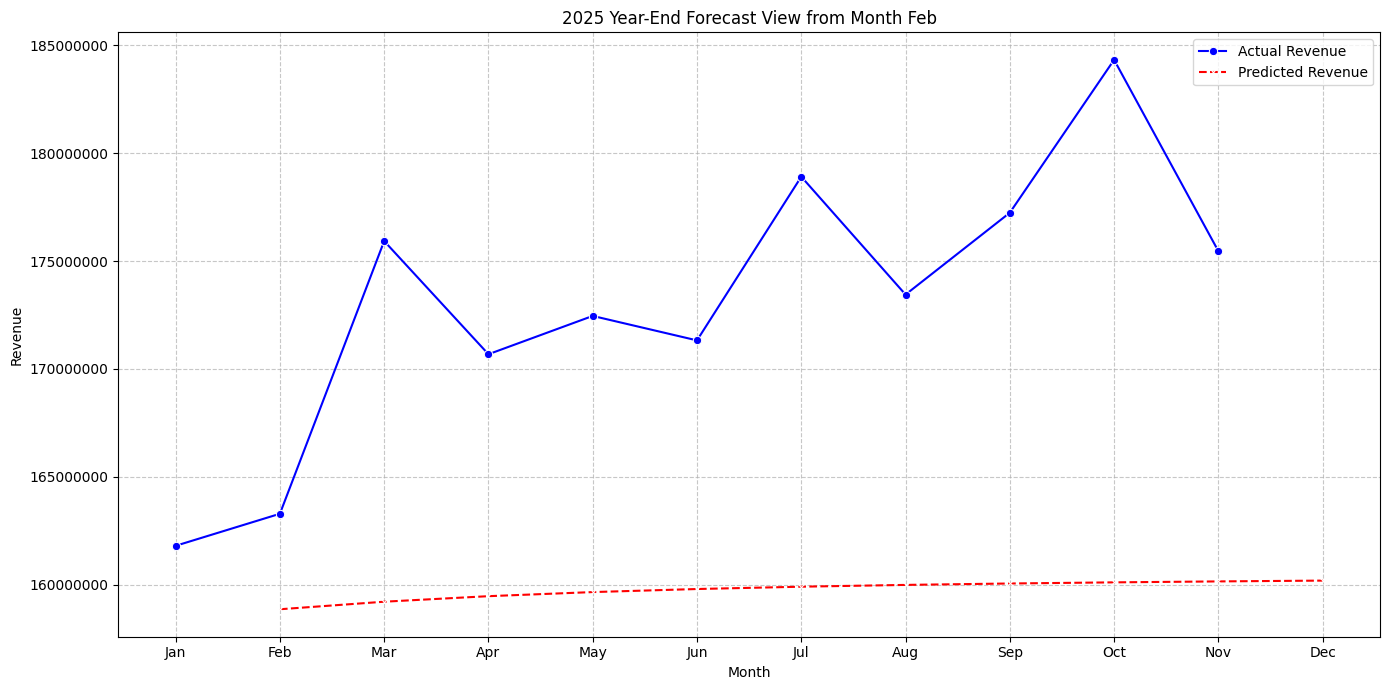

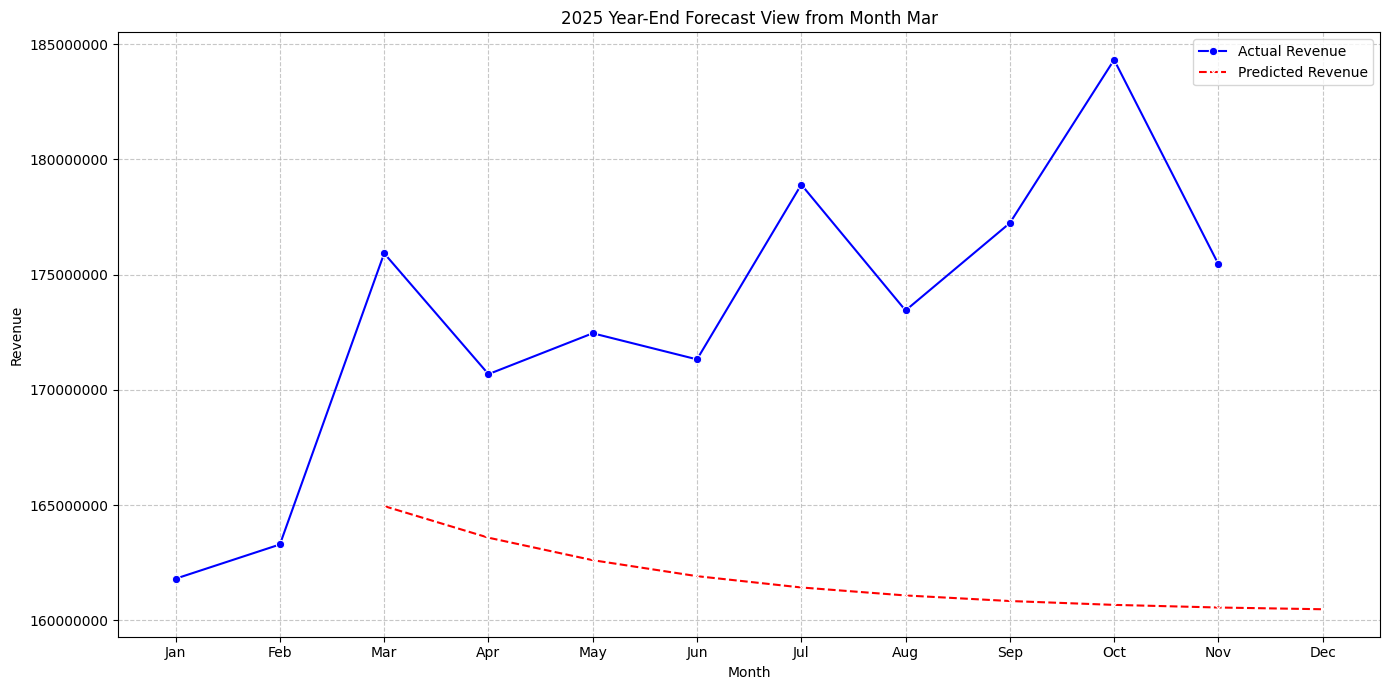

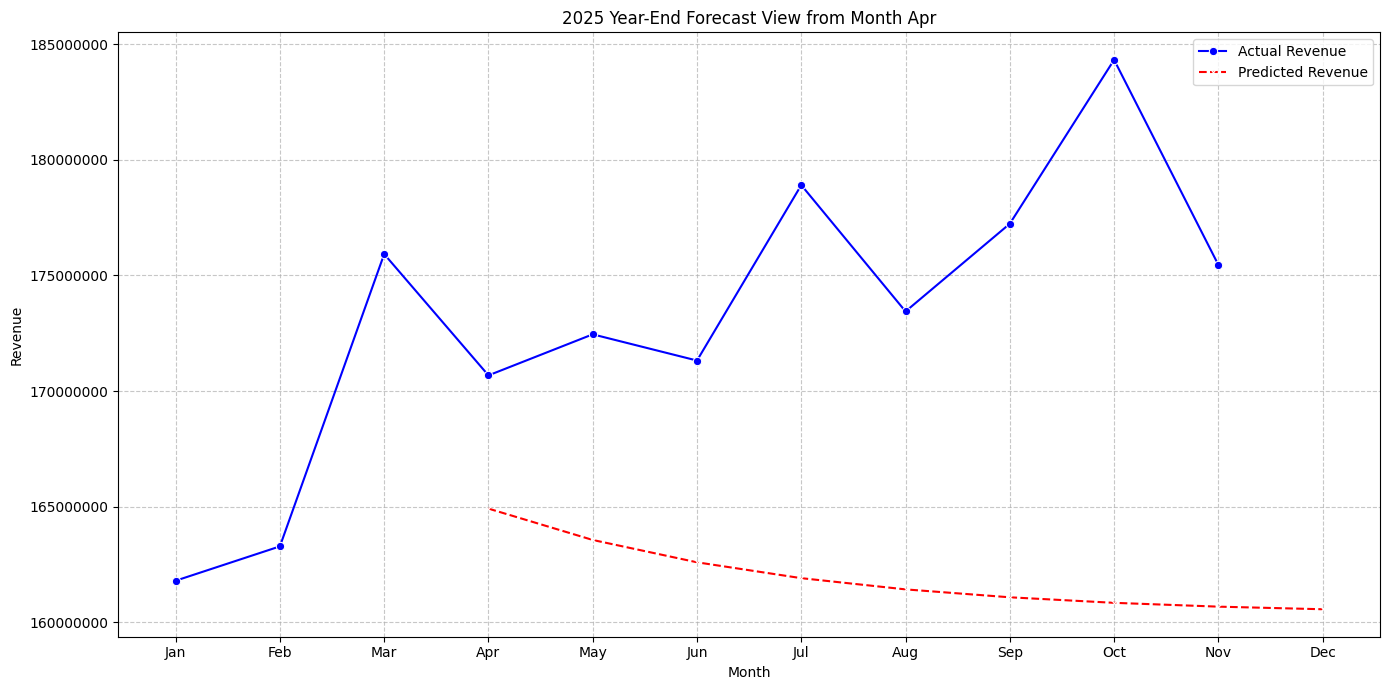

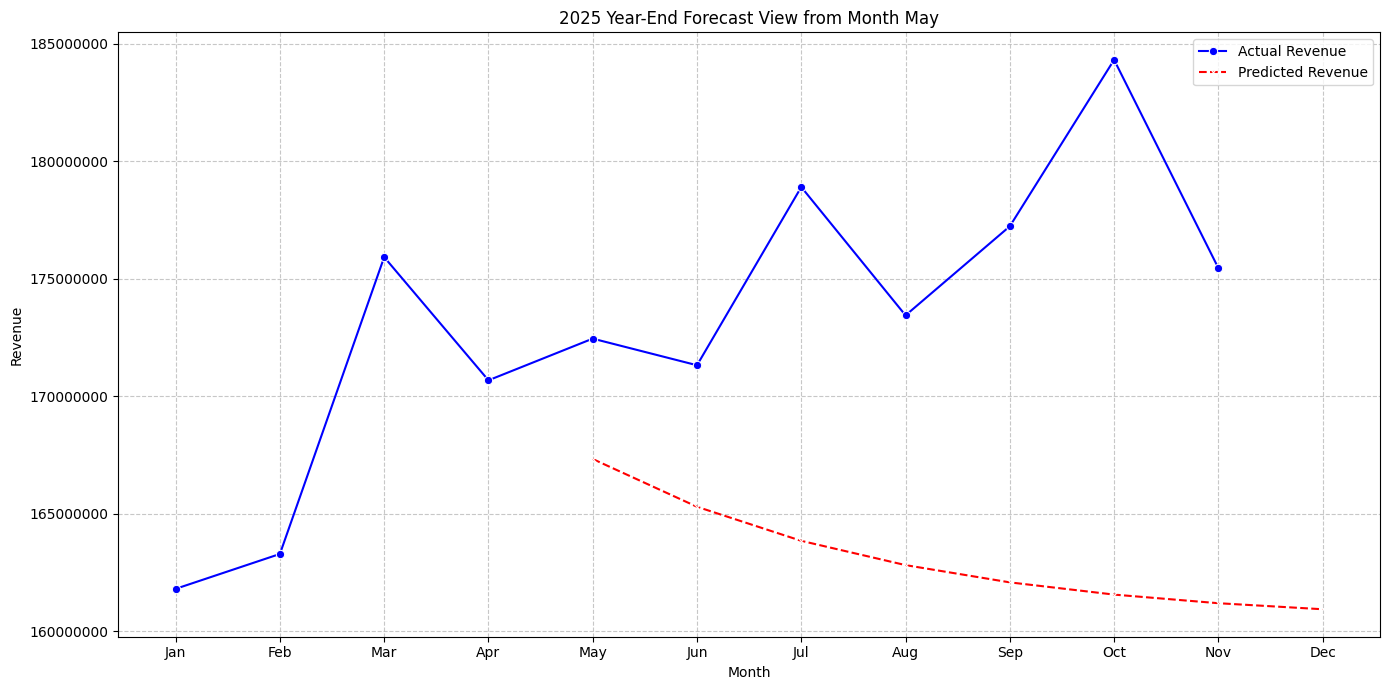

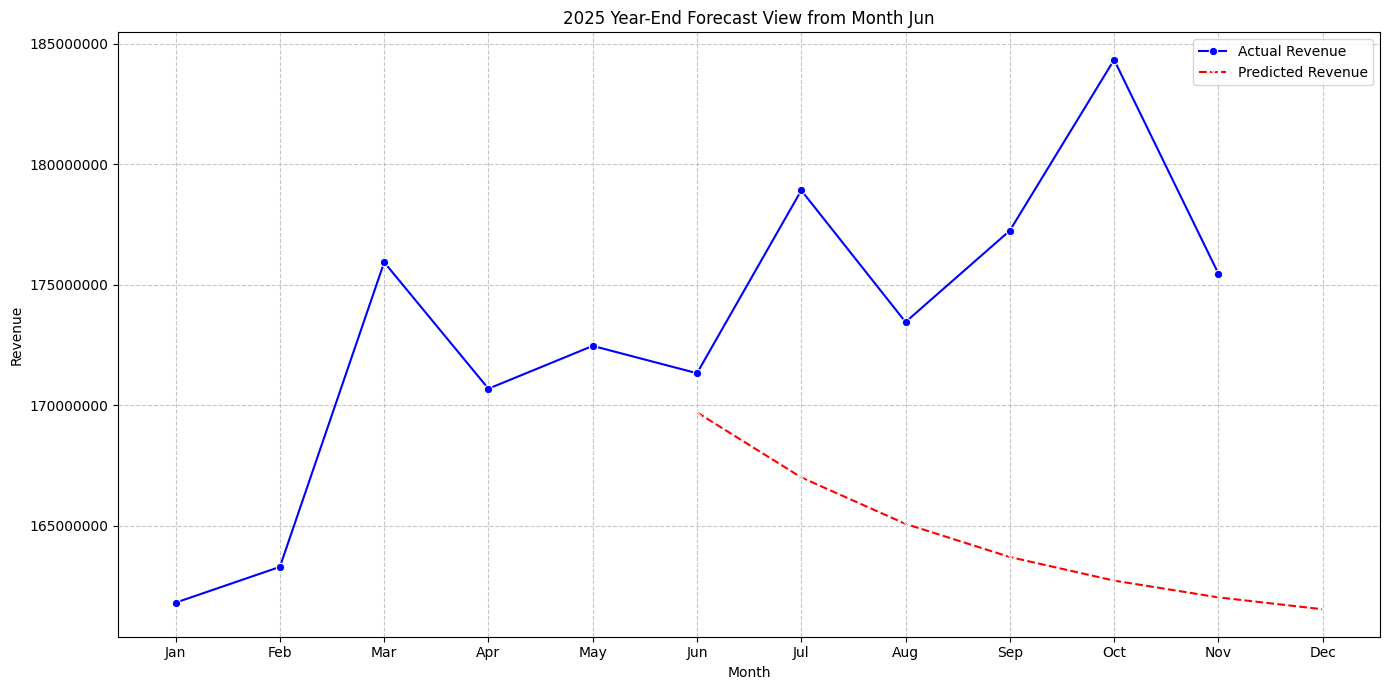

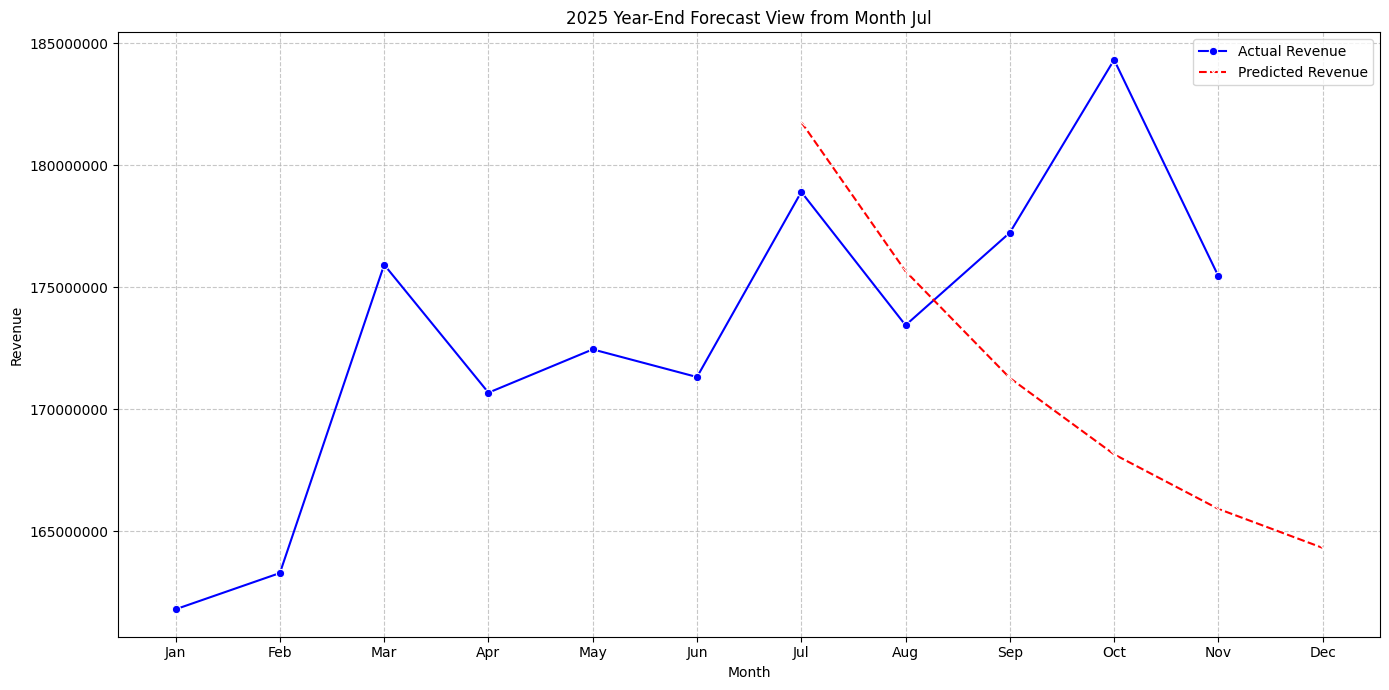

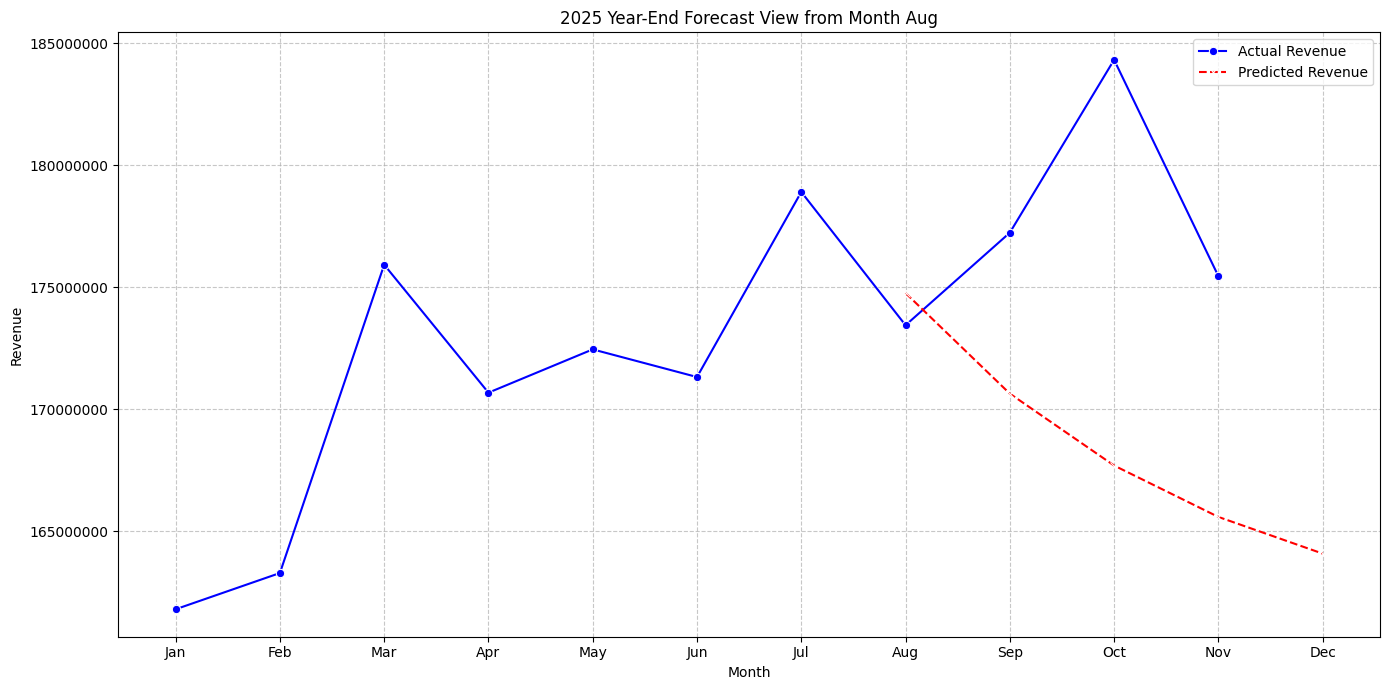

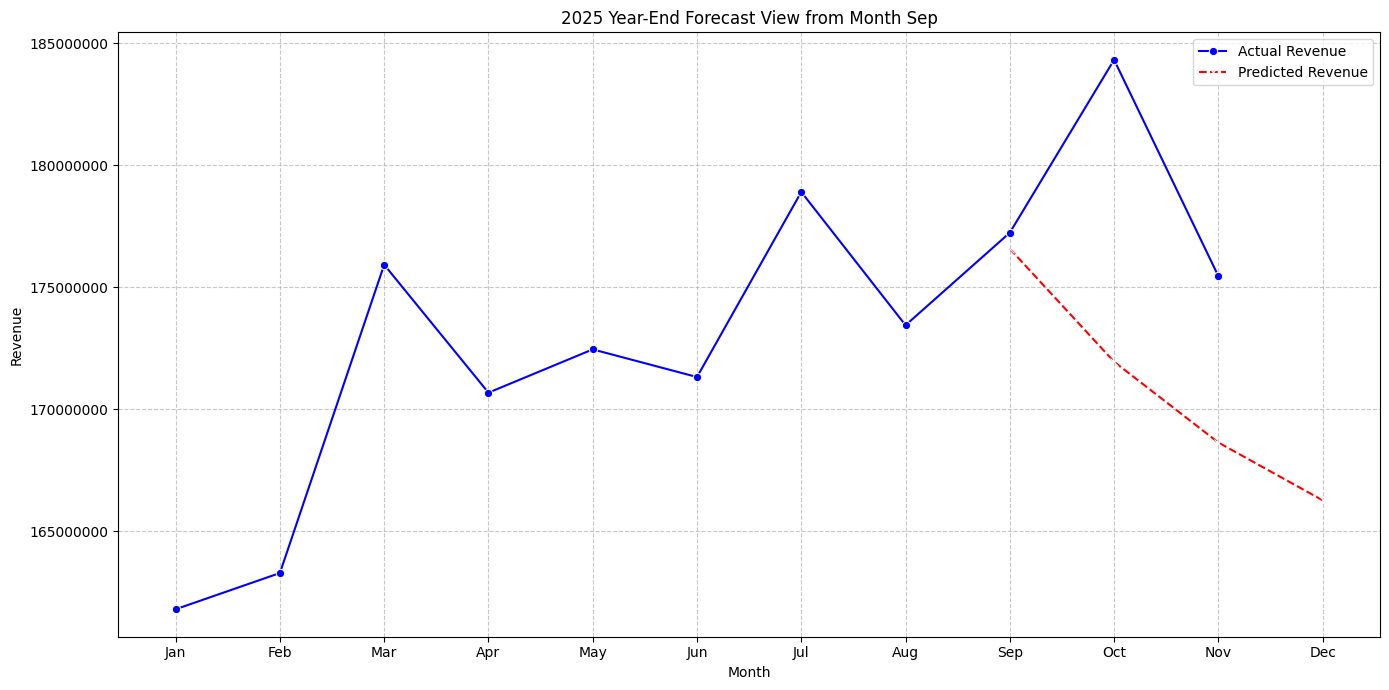

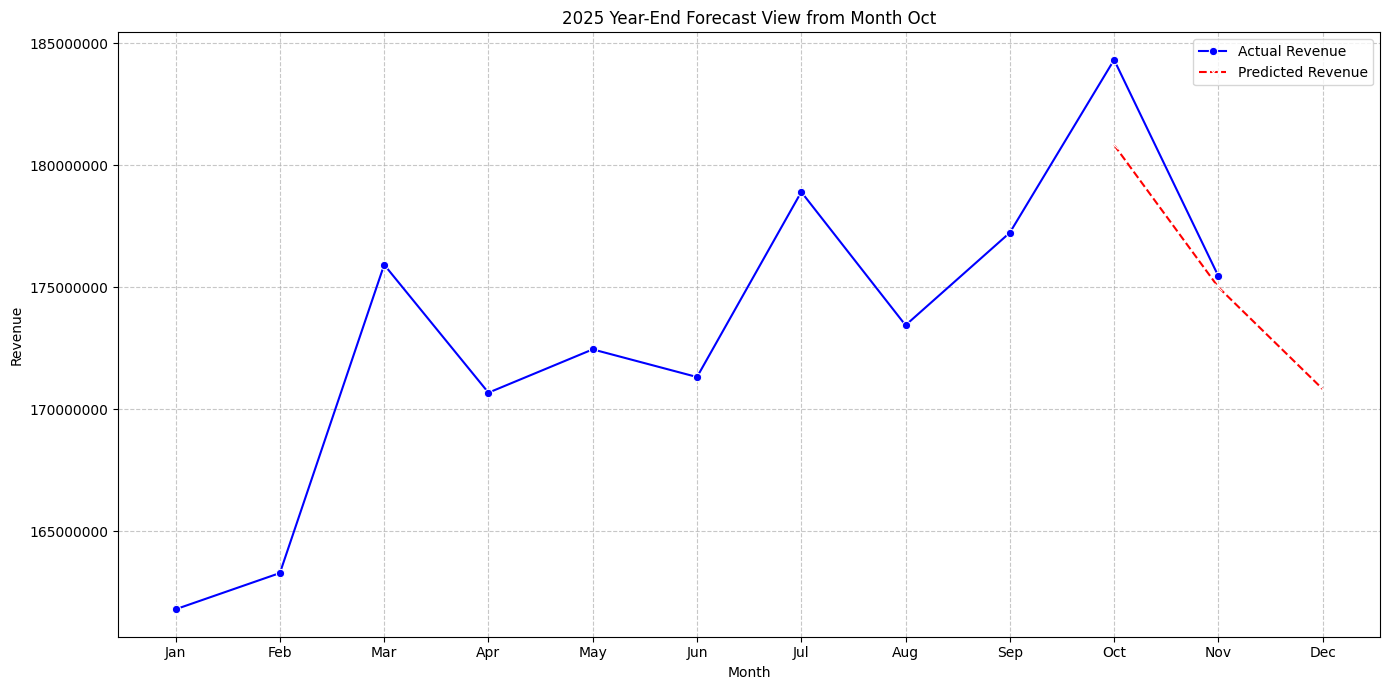

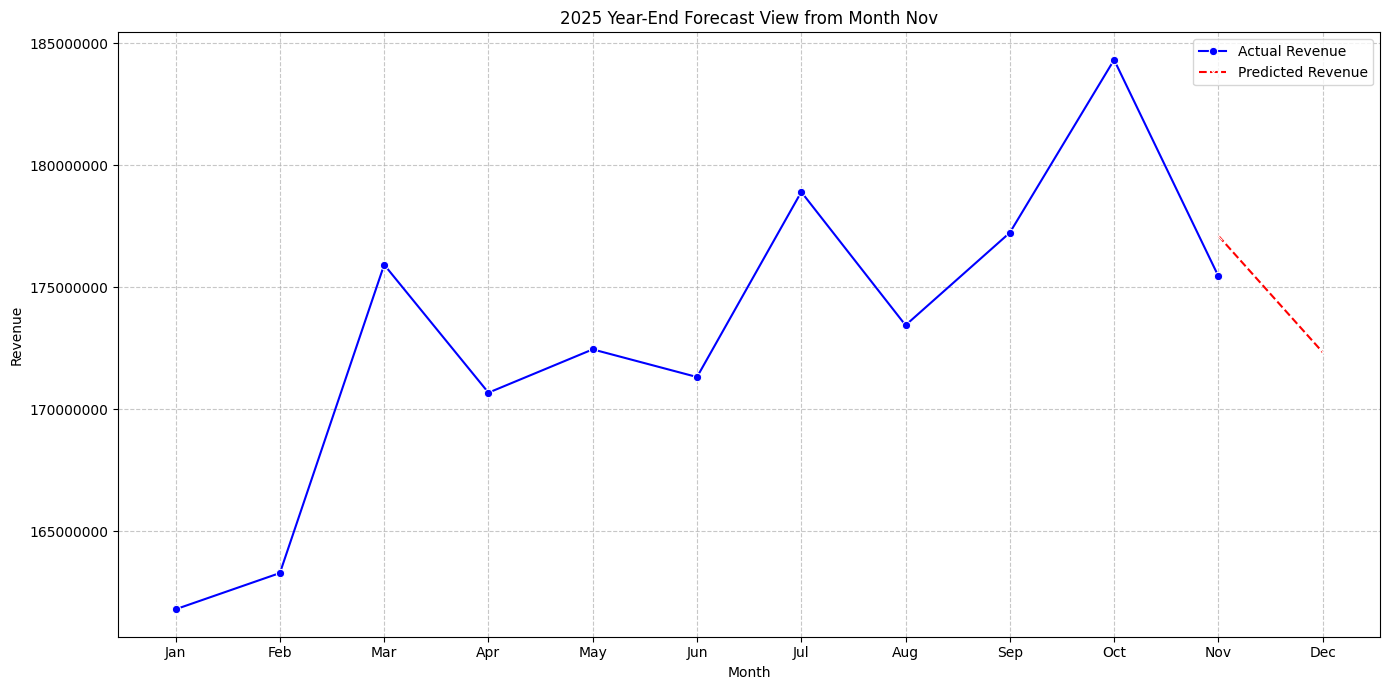

✅ All rolling forecast plots generated!


In [94]:
print("📊 Generating rolling forecast plots for each sitting month...")

month_names_dict = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

import seaborn as sns

# Iterate through each sitting_month from 1 (January) to 11 (November)
for sitting_month in range(1, 12):
    plot_data_current_view = []
    sitting_month_name = month_names_dict[sitting_month]

    # Iterate through each month m from 1 to 12 (January to December)
    for m in range(1, 13):
        month_name = month_names_dict[m]
        current_actual = np.nan
        current_predicted = np.nan

        if m < sitting_month:
            # Retrieve actual revenue for months before the sitting month
            actual_row = test_df[(test_df['year'] == 2025) & (test_df['month_num'] == m) & (test_df['actual_revenue'].notna())]
            if not actual_row.empty:
                current_actual = actual_row['actual_revenue'].values[0]
        else:
            # Retrieve predictions from the current sitting month onwards
            prediction_row = monthly_results[
                (monthly_results['start_month'] == sitting_month) &
                (monthly_results['forecast_month'] == m)
            ]
            if not prediction_row.empty:
                current_predicted = prediction_row['predicted'].values[0]
                if not prediction_row['is_imputed'].values[0]:
                    # If actual value exists for this forecast month (not imputed)
                    current_actual = prediction_row['actual'].values[0]

        plot_data_current_view.append({'month_name': month_name, 'actual': current_actual, 'predicted': current_predicted})

    df_plot = pd.DataFrame(plot_data_current_view)

    plt.figure(figsize=(14, 7))
    sns.lineplot(x='month_name', y='actual', data=df_plot, marker='o', label='Actual Revenue', color='blue')
    sns.lineplot(x='month_name', y='predicted', data=df_plot, marker='x', linestyle='--', label='Predicted Revenue', color='red')

    plt.title(f'2025 Year-End Forecast View from Month {sitting_month_name}')
    plt.xlabel('Month')
    plt.ylabel('Revenue')
    plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("✅ All rolling forecast plots generated!")

# SAVE ENHANCED MODEL AND FEATURES

In [ ]:
# Save features and coefficients
#coefficients.to_csv('feature_importance_enhanced.csv', index=False)

# Save full dataset with new features
#full_features = ['date'] + ALL_FEATURES
#df[full_features].to_excel('revenue_features_enhanced.xlsx')

print("Files saved successfully:")
print("  1. feature_importance_enhanced.csv - Feature importance scores")
print("  2. revenue_features_enhanced.xlsx - Full dataset with enhanced features")

# SUMMARY OF ENHANCEMENTS